# Figure 5 - Mouse

In [65]:
import os
from pathlib import Path
import pickle

import scanpy as sc
import anndata

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotnine as p9

from tqdm.auto import tqdm
from sklearn.metrics import adjusted_rand_score

import scvelo as scv
from io import StringIO

In [2]:
sc.set_figure_params(dpi=100)
plt.rcParams['pdf.fonttype'] = 42
sc.settings.figdir = 'figures/'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys

sys.path.append(str(Path.home() / 'Code/sctoolkit/'))

In [5]:
from sctoolkit.proportions import plot_proportion_barplot, plot_proportion_barplot_cellcounts, plot_proportion_barplot_single_categorical, plot_proportion_barplot_with_ncells, merge_ggplots, dirichletreg, get_proportions_per_channel
from sctoolkit.utils import plot_significance_dotplot, run_spring, dotplot_spring
from sctoolkit.sctransform import sctransform

## Read data

In [135]:
adata = sc.read('mouse-muscle.h5ad')
adata

AnnData object with n_obs × n_vars = 24776 × 17269
    obs: '10x_cell_calling', 'raw', 'Unique_ID', 'Sample_ID', 'sample_name', 'Mouse_ID', 'Segment', 'Region', 'Overload', 'Date_run', 'Date_sequenced', 'Barcode', 'Raw_Data', 'Data', 'Dataset', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac', 'n_counts', 'scrublet', 'scrublet_score', 'predicted_sex', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_cell_types', 'sample_leiden', 'predicted_cell_types_coarse', 'tm_predictions', 'tms_predictions', 'Trem2+', 'Cell type', 'leiden_sub', 'Tissue', 'channel', 'Cell type numbers', 'Cell type (numbers)'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm', 'mean', 'std', 'highly_variable_nbatches', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length'
  

In [137]:
pd.options.display.max_columns = None

In [71]:
human_muscle = sc.read('../alltissue_v5__myocytes_20210204.h5ad')
human_muscle = human_muscle[human_muscle.obs.Tissue.isin(['Heart', 'Esophagus muscularis', 'Skeletal muscle'])].copy()
human_muscle

AnnData object with n_obs × n_vars = 101624 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', '

## UMAP

In [7]:
# from https://github.com/theislab/scanpy/issues/1513#issuecomment-735051689 Thanks to ivirshup

from adjustText import adjust_text

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [ ]:
import matplotlib.patheffects as p

# Donated generously by ivirshup https://github.com/theislab/scanpy/issues/1513#issuecomment-735051689
with plt.rc_context({"figure.figsize": (12, 12), "figure.dpi": 300, "figure.frameon": False}):
    ax = sc.pl.umap(adata, color="Cell type (numbers)", show=False, legend_loc=None, frameon=False, add_outline=False, outline_width=(0.1,0.1), size=10)
    pe = [p.withStroke(linewidth=2, foreground='w')]
    gen_mpl_labels(
        adata,
        "Cell type (numbers)",
        exclude=("None",),  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=12, path_effects=pe),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

In [72]:
human_muscle.obs['Broad cell type'].cat.categories

Index(['Adipocyte', 'Endothelial cell (lymphatic)',
       'Endothelial cell (vascular)', 'Fibroblast', 'ICCs', 'Immune (B cell)',
       'Immune (DC/macrophage)', 'Immune (NK cell)', 'Immune (T cell)',
       'Immune (mast cell)', 'Myocyte (NMJ-rich)', 'Myocyte (cardiac)',
       'Myocyte (cardiac, cytoplasmic)', 'Myocyte (sk. muscle)',
       'Myocyte (sk. muscle, cytoplasmic)', 'Myocyte (smooth muscle)',
       'Neuronal', 'Pericyte/SMC', 'Satellite cell', 'Schwann cell'],
      dtype='object')

In [83]:
adata[adata.obs.Region == 'esophagus'].obs['Cell type'].cat.categories

Index(['Adipocyte', 'B cell', 'Basal epithelia', 'Enterocyte', 'Fibroblast',
       'LEC', 'Macrophage/DC', 'Myocyte', 'Myocyte (cytoplasmic)',
       'Myocyte (smooth muscle)', 'Myocyte (smooth muscle, Ryr3+)', 'Neuronal',
       'Parathyroid gland cell', 'Pericyte', 'Satellite cell', 'Schwann cell',
       'Suprabasal epithelia', 'T cell', 'VEC', 'VEC (Cldn5+)'],
      dtype='object')

In [85]:
mouse2human_skm = {
    'Adipocyte': 'Adipocyte',
    'B cell': 'Immune (B cell)', 
    'Fibroblast': 'Fibroblast',
    'LEC': 'Endothelial cell (lymphatic)',
    'Macrophage/DC': 'Immune (DC/macrophage)', 
    'Myocyte': 'Myocyte (sk. muscle)', 
    'Myocyte (NMJ-rich)': 'Myocyte (NMJ-rich)',
    'Myocyte (cytoplasmic)': 'Myocyte (sk. muscle, cytoplasmic)', 
    'Myocyte (smooth muscle)': 'Pericyte/SMC',
    'Pericyte': 'Pericyte/SMC',
    'Satellite cell': 'Satellite cell',
    'Schwann cell': 'Schwann cell',
    'T cell': 'Immune (T cell)',
    'VEC': 'Endothelial cell (vascular)', 
    'VEC (Cldn5+)': 'Endothelial cell (vascular)',
}

mouse2human_heart = {
    'Adipocyte': 'Adipocyte',
    'B cell': 'Immune (B cell)', 
    'Cardiomyocyte': 'Myocyte (cardiac)',
    'Cardiomyocyte (cytoplasmic)': 'Myocyte (cardiac, cytoplasmic)',
    'Fibroblast': 'Fibroblast',
    'LEC': 'Endothelial cell (lymphatic)',
    'Macrophage/DC': 'Immune (DC/macrophage)', 
    'Myocyte (smooth muscle)': 'Pericyte/SMC',
    'Pericyte': 'Pericyte/SMC',
    'Schwann cell': 'Schwann cell',
    'T cell': 'Immune (T cell)',
    'VEC': 'Endothelial cell (vascular)', 
    'VEC (Cldn5+)': 'Endothelial cell (vascular)',
    'VEC (Npr3+)': 'Endothelial cell (vascular)',
}

mouse2human_eso = {
    'Adipocyte': 'Adipocyte',
    'B cell': 'Immune (B cell)', 
    'Basal epithelia': 'Epithelial cell (basal)',
    'Enterocyte': 'Enterocyte',
    'Fibroblast': 'Fibroblast',
    'Myocyte': 'Myocyte',         
    'Myocyte (cytoplasmic)': 'Myocyte (cytoplasmic)',     
    'Myocyte (smooth muscle)': 'Myocyte (smooth muscle)',
    'Myocyte (smooth muscle, Ryr3+)': 'Myocyte (smooth muscle)', 
    'Neuronal': 'Neuronal', 
    'Parathyroid gland cell': 'Parathyroid gland cell',
    'Pericyte': 'Pericyte/SMC',
    'Satellite cell': 'Satellite cell',
    'Schwann cell': 'Schwann cell',
    'Suprabasal epithelia': 'Epithelial cell (basal)',
    'T cell': 'Immune (T cell)',
    'VEC': 'Endothelial cell (vascular)', 
    'VEC (Cldn5+)': 'Endothelial cell (vascular)',
}

In [86]:
adata.obs['Cell type v2'] = adata.obs['Cell type'].astype(str)

adata.obs['Cell type v2'].loc[(adata.obs['Region'] == 'skeletal_muscle_edl')] = adata.obs['Cell type v2'].loc[(adata.obs['Region'] == 'skeletal_muscle_edl')].map(mouse2human_skm)
adata.obs['Cell type v2'].loc[(adata.obs['Region'] == 'heart')] = adata.obs['Cell type v2'].loc[(adata.obs['Region'] == 'heart')].map(mouse2human_heart)
adata.obs['Cell type v2'].loc[(adata.obs['Region'] == 'esophagus')] = adata.obs['Cell type v2'].loc[(adata.obs['Region'] == 'esophagus')].map(mouse2human_eso)

adata._sanitize()

... storing 'Cell type v2' as categorical


In [92]:
m_skm = adata[adata.obs.Region == 'skeletal_muscle_edl'].copy()
m_heart = adata[adata.obs.Region == 'heart'].copy()
m_eso = adata[adata.obs.Region == 'esophagus'].copy()

h_skm = human_muscle[human_muscle.obs.Tissue == 'Skeletal muscle'].copy()
h_heart = human_muscle[human_muscle.obs.Tissue == 'Heart'].copy()
h_eso = human_muscle[human_muscle.obs.Tissue == 'Esophagus muscularis'].copy()

In [100]:
for h,m in ((h_skm, m_skm), (h_heart, m_heart), (h_eso, m_eso)):
    common = sorted(list(set(m.obs['Cell type v2'].cat.categories) & set(h.obs['Broad cell type'].cat.categories)))
    honly = sorted(list(set(h.obs['Broad cell type'].cat.categories) - set(m.obs['Cell type v2'].cat.categories)))
    monly = sorted(list(set(m.obs['Cell type v2'].cat.categories) - set(h.obs['Broad cell type'].cat.categories)))
    
    m.obs['Cell type v2'].cat.reorder_categories(common + monly, inplace=True)
    h.obs['Broad cell type'].cat.reorder_categories(common + honly, inplace=True)    

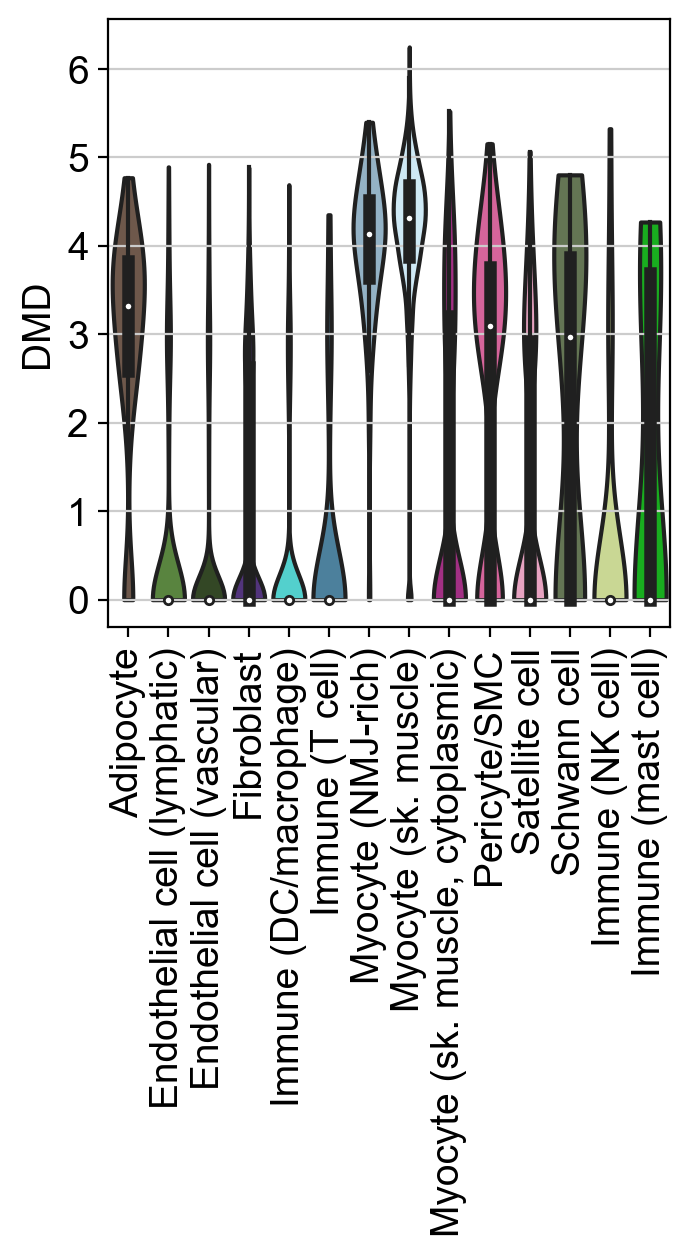

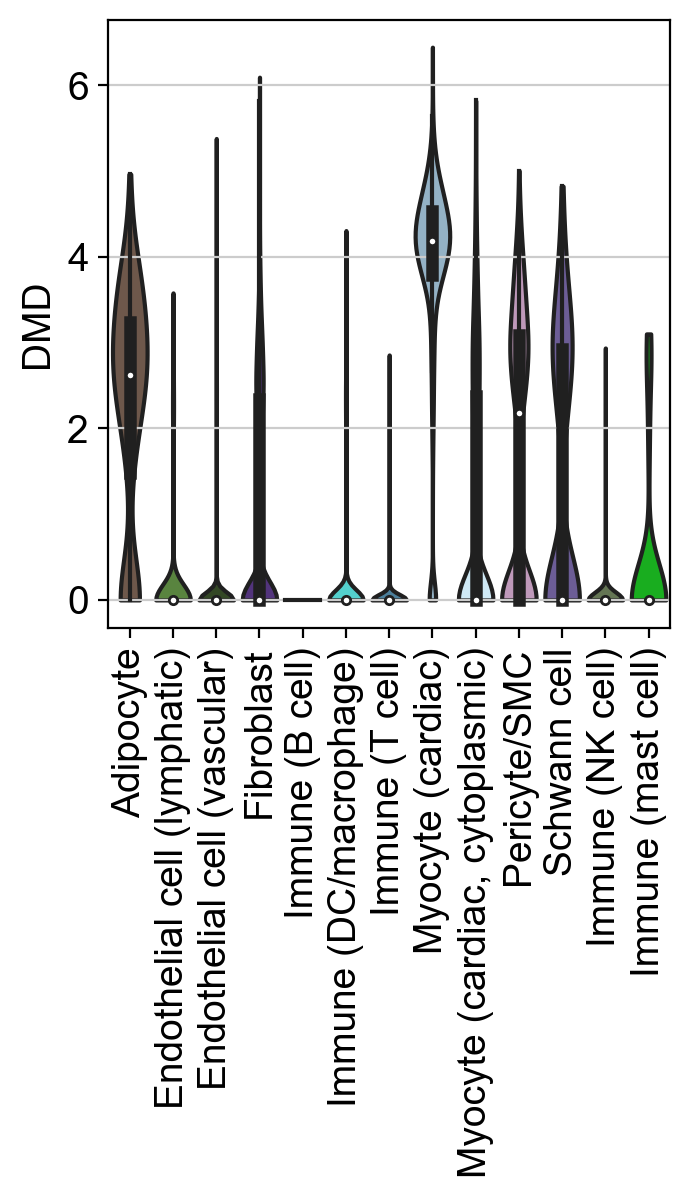

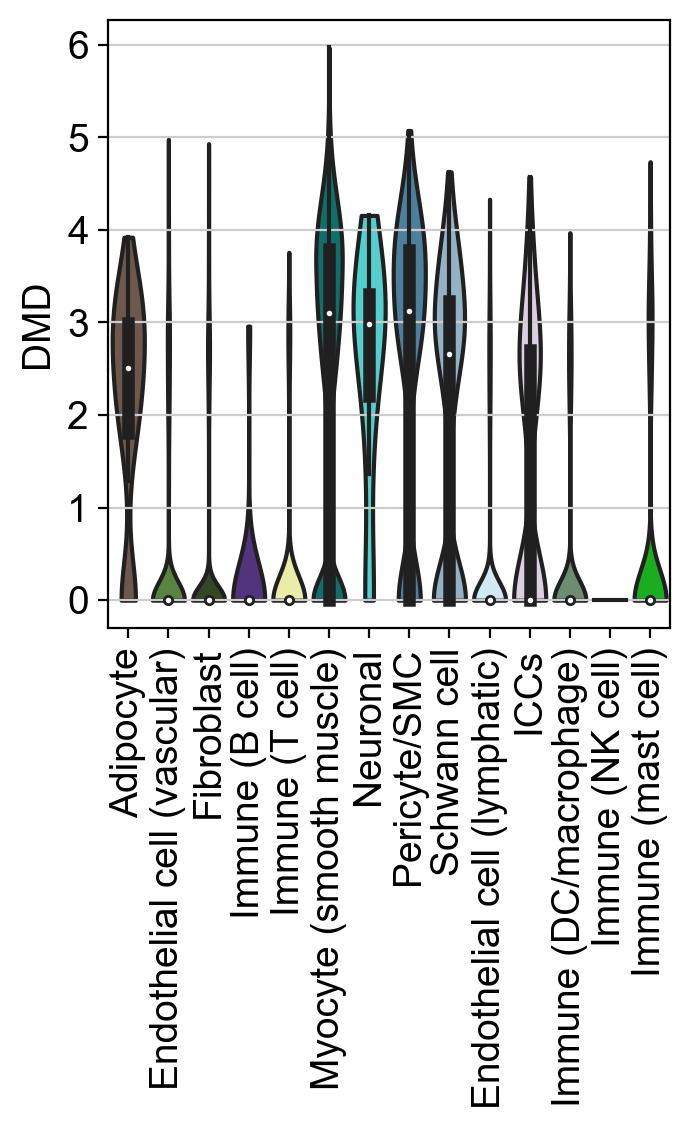

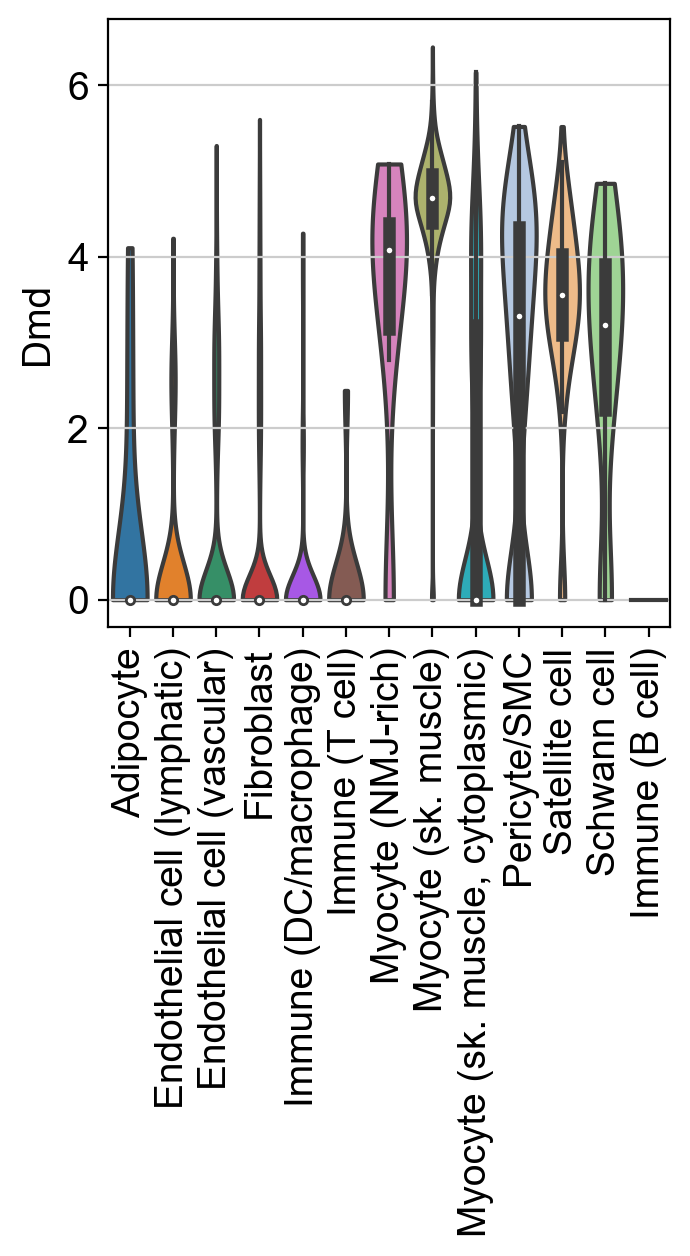

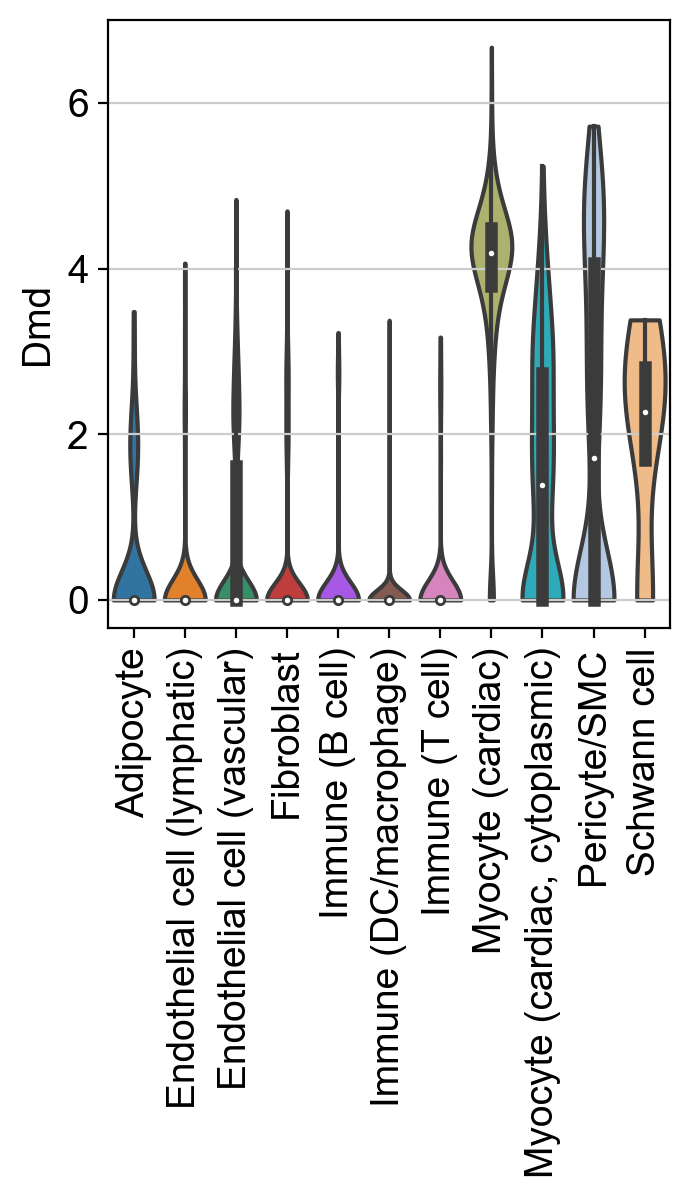

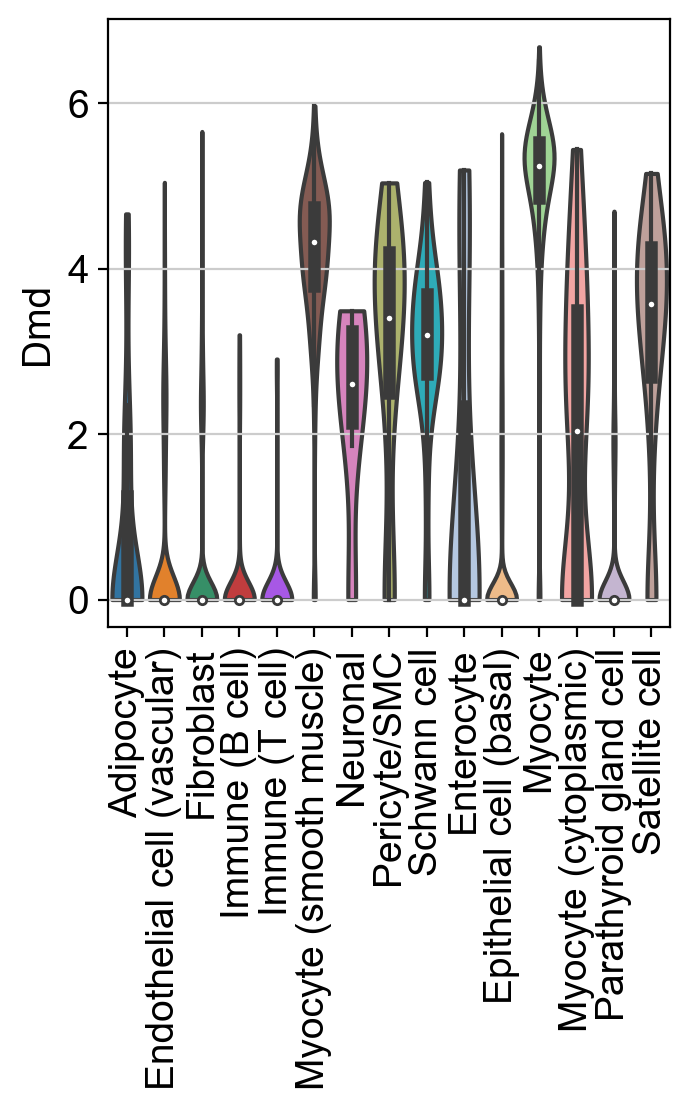

In [102]:
sc.pl.violin(h_skm, 'DMD', 'Broad cell type', rotation=90, inner='box', stripplot=False, save='Figure5-C1-skm.pdf', use_raw=False)
sc.pl.violin(h_heart, 'DMD', 'Broad cell type', rotation=90, inner='box', stripplot=False, save='Figure5-C2-heart.pdf', use_raw=False)
sc.pl.violin(h_eso, 'DMD', 'Broad cell type', rotation=90, inner='box', stripplot=False, save='Figure5-C3-esophagusmusc.pdf', use_raw=False)

sc.pl.violin(m_skm, 'Dmd', 'Cell type v2', rotation=90, inner='box', stripplot=False, save='Figure5-D1-skm.pdf')
sc.pl.violin(m_heart, 'Dmd', 'Cell type v2', rotation=90, inner='box', stripplot=False, save='Figure5-D2-heart.pdf')
sc.pl.violin(m_eso, 'Dmd', 'Cell type v2', rotation=90, inner='box', stripplot=False, save='Figure5-D3-esophagus.pdf')

In [9]:
fig.savefig(sc.settings.figdir / 'Figure-S04-1A.pdf', dpi=300)

In [10]:
sc.set_figure_params(vector_friendly=True, figsize=(10,10))
sc.pl.umap(adata, color='Tissue', size=5, save='Figure-S04-1B.pdf', show=False, add_outline=False, outline_width=(0.1,0.1), frameon=False)

<AxesSubplot:title={'center':'Tissue'}, xlabel='UMAP1', ylabel='UMAP2'>

In [11]:
idx = np.arange(adata.shape[0])
np.random.shuffle(idx)

In [12]:
sc.set_figure_params(vector_friendly=True, figsize=(7,7))
sc.pl.umap(adata[idx], color=['Mouse_ID', 'Sample_ID'], show=False, ncols=2, size=5, save='Figure-S04-1C.pdf', frameon=False, title=['Mouse ID', 'Sample ID'], sort_order=False)

[<AxesSubplot:title={'center':'Mouse ID'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Sample ID'}, xlabel='UMAP1', ylabel='UMAP2'>]

## Compositions

In [13]:
exclude_channels = adata.obs.channel.value_counts() < 30
exclude_channels = exclude_channels[exclude_channels].index
exclude_channels

CategoricalIndex([], categories=['esophagus_M2_S8', 'esophagus_M3_S12', 'heart_M2_S5', 'heart_M3_S9', 'skeletal_muscle_edl_M2_S7', 'skeletal_muscle_edl_M3_S11'], ordered=False, dtype='category')

In [14]:
ad = adata[~adata.obs.Sample_ID.isin(exclude_channels)]

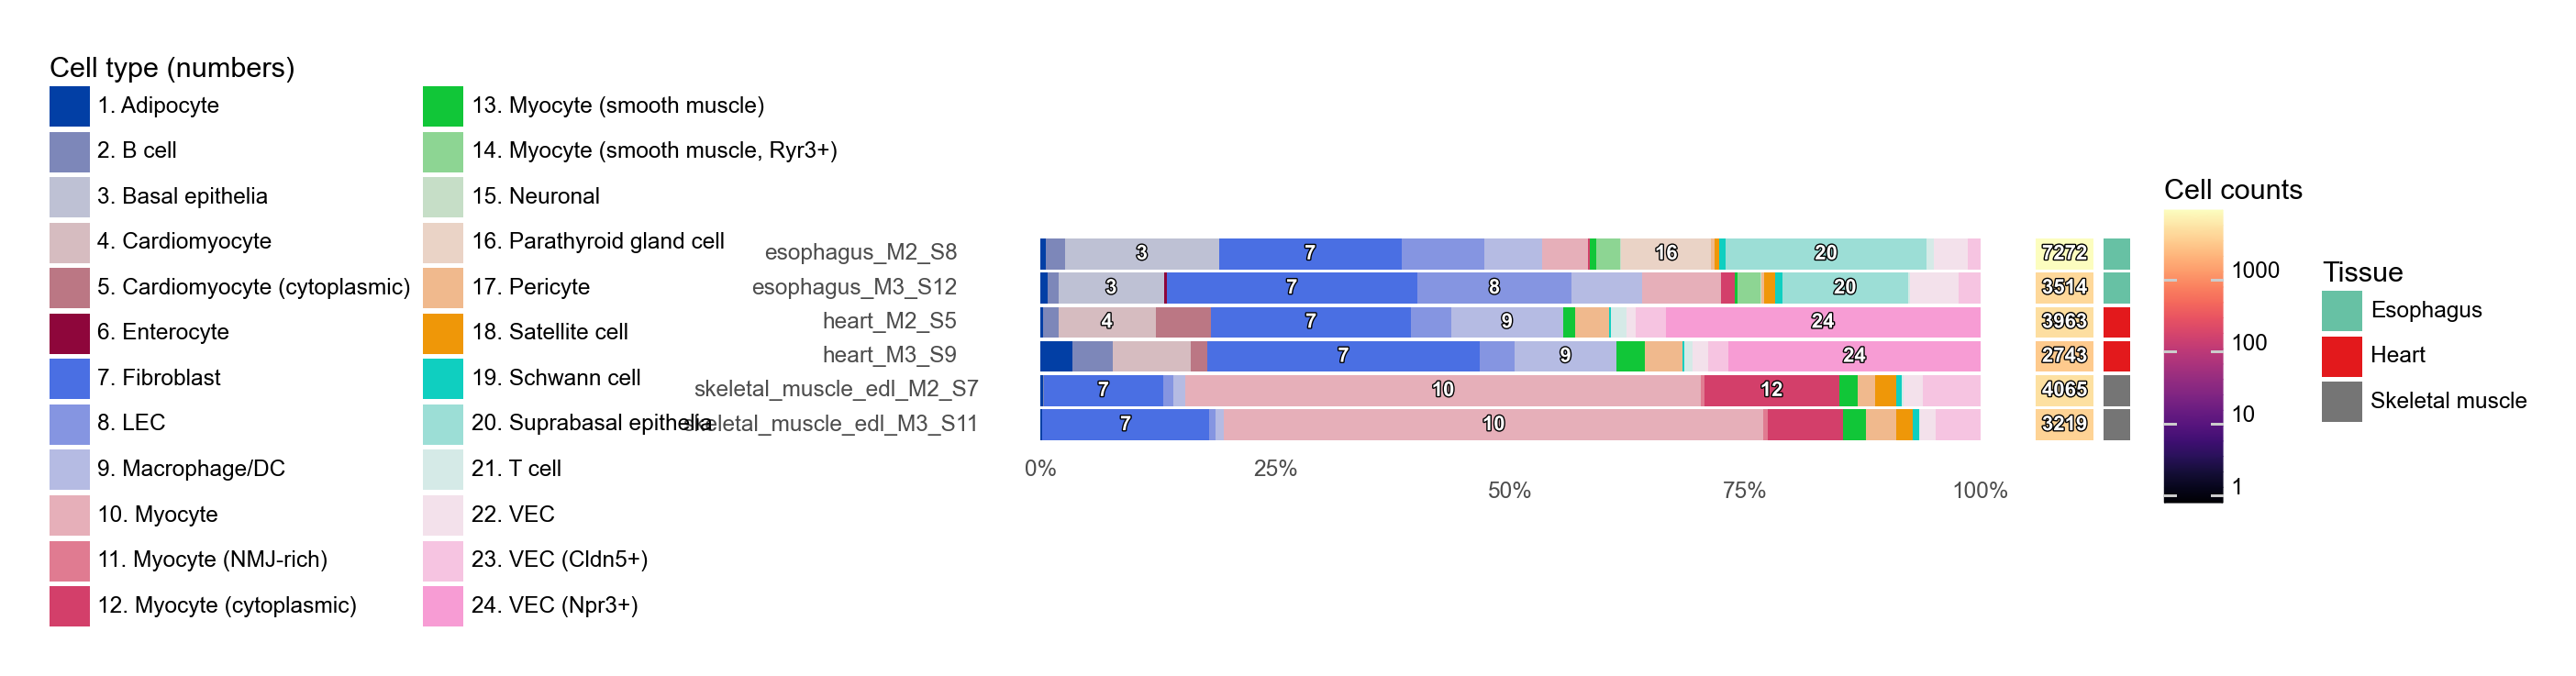

In [15]:
f1 = plot_proportion_barplot(ad, 'channel', 'Cell type (numbers)', legend_position=(-0.25,0.5), percent_limit=10, external_percent_label='Cell type numbers')
f2 = plot_proportion_barplot_cellcounts(ad, 'channel', legend_position=(0.97,0.5))
f3 = plot_proportion_barplot_single_categorical(ad, 'channel', 'Tissue', legend_position=(1.1,0.5))

f = merge_ggplots(f1, f2, f3, units=[30, 2, 1], figsize=(8,1.5))
f.savefig( sc.settings.figdir / 'Figure-S04-1E.pdf', bbox_inches = "tight")

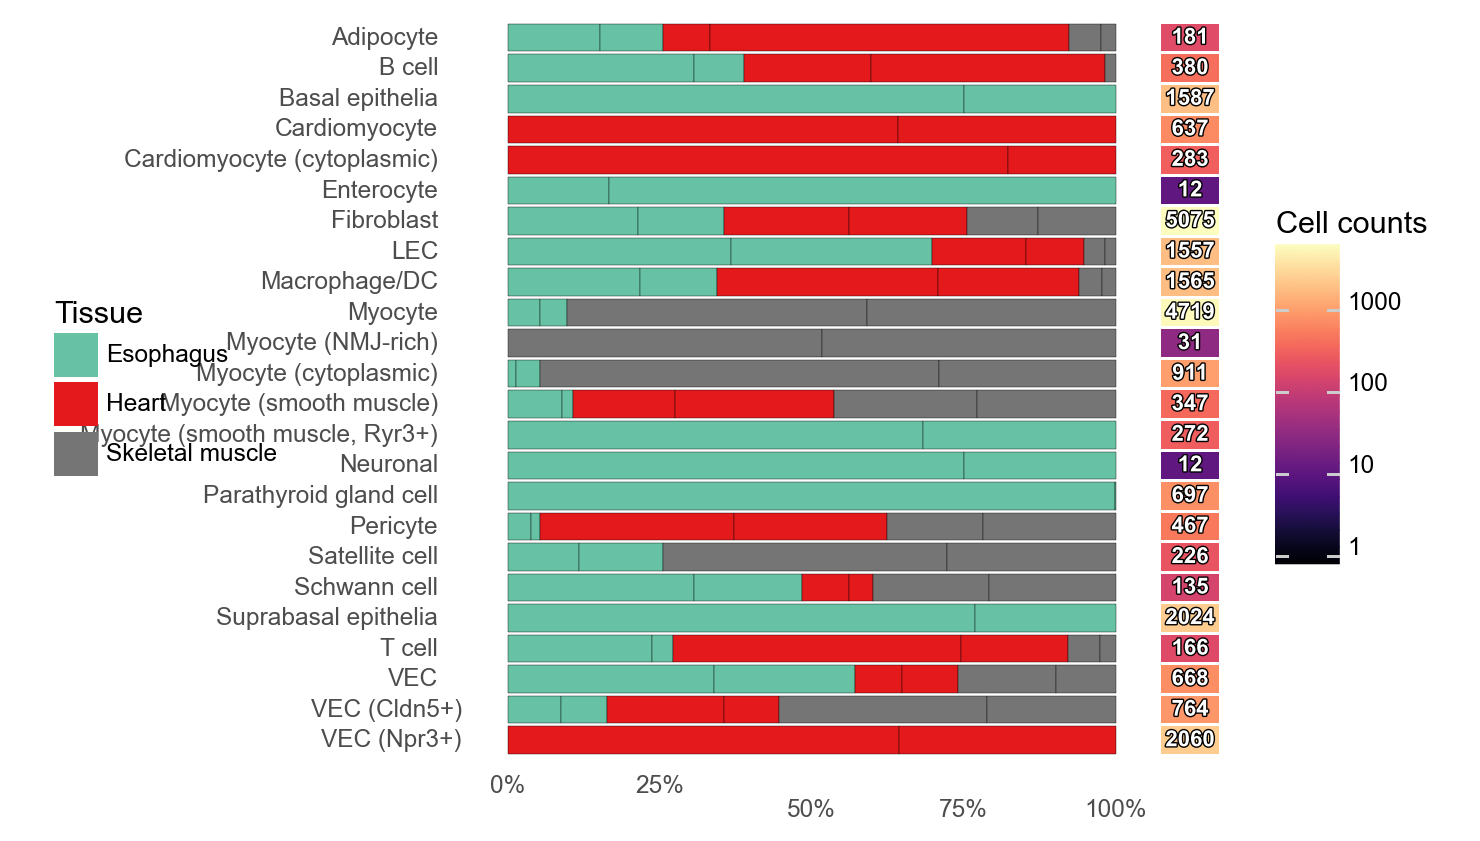

In [16]:
f = plot_proportion_barplot_with_ncells(adata, 'Cell type', 'Tissue', 'channel', normalize_by='Tissue', show_percent=False, height_scale=0.5, width_scale=0.4)
f.savefig( sc.settings.figdir / 'Figure-S04-1F.pdf', bbox_inches = "tight")

f = plot_proportion_barplot_with_ncells(adata, 'Tissue', 'Cell type', 'channel', legend_position=(-.2, 0.5))
f.savefig( sc.settings.figdir /  'tissue-celltype-compositions.pdf', bbox_inches = "tight")

## Markers

### Sk muscle

In [17]:
ad = adata[adata.obs.Region == 'skeletal_muscle_edl']

In [18]:
#df = run_spring(ad, 'Cell type')
#dotplot_spring(ad, 'Cell type')

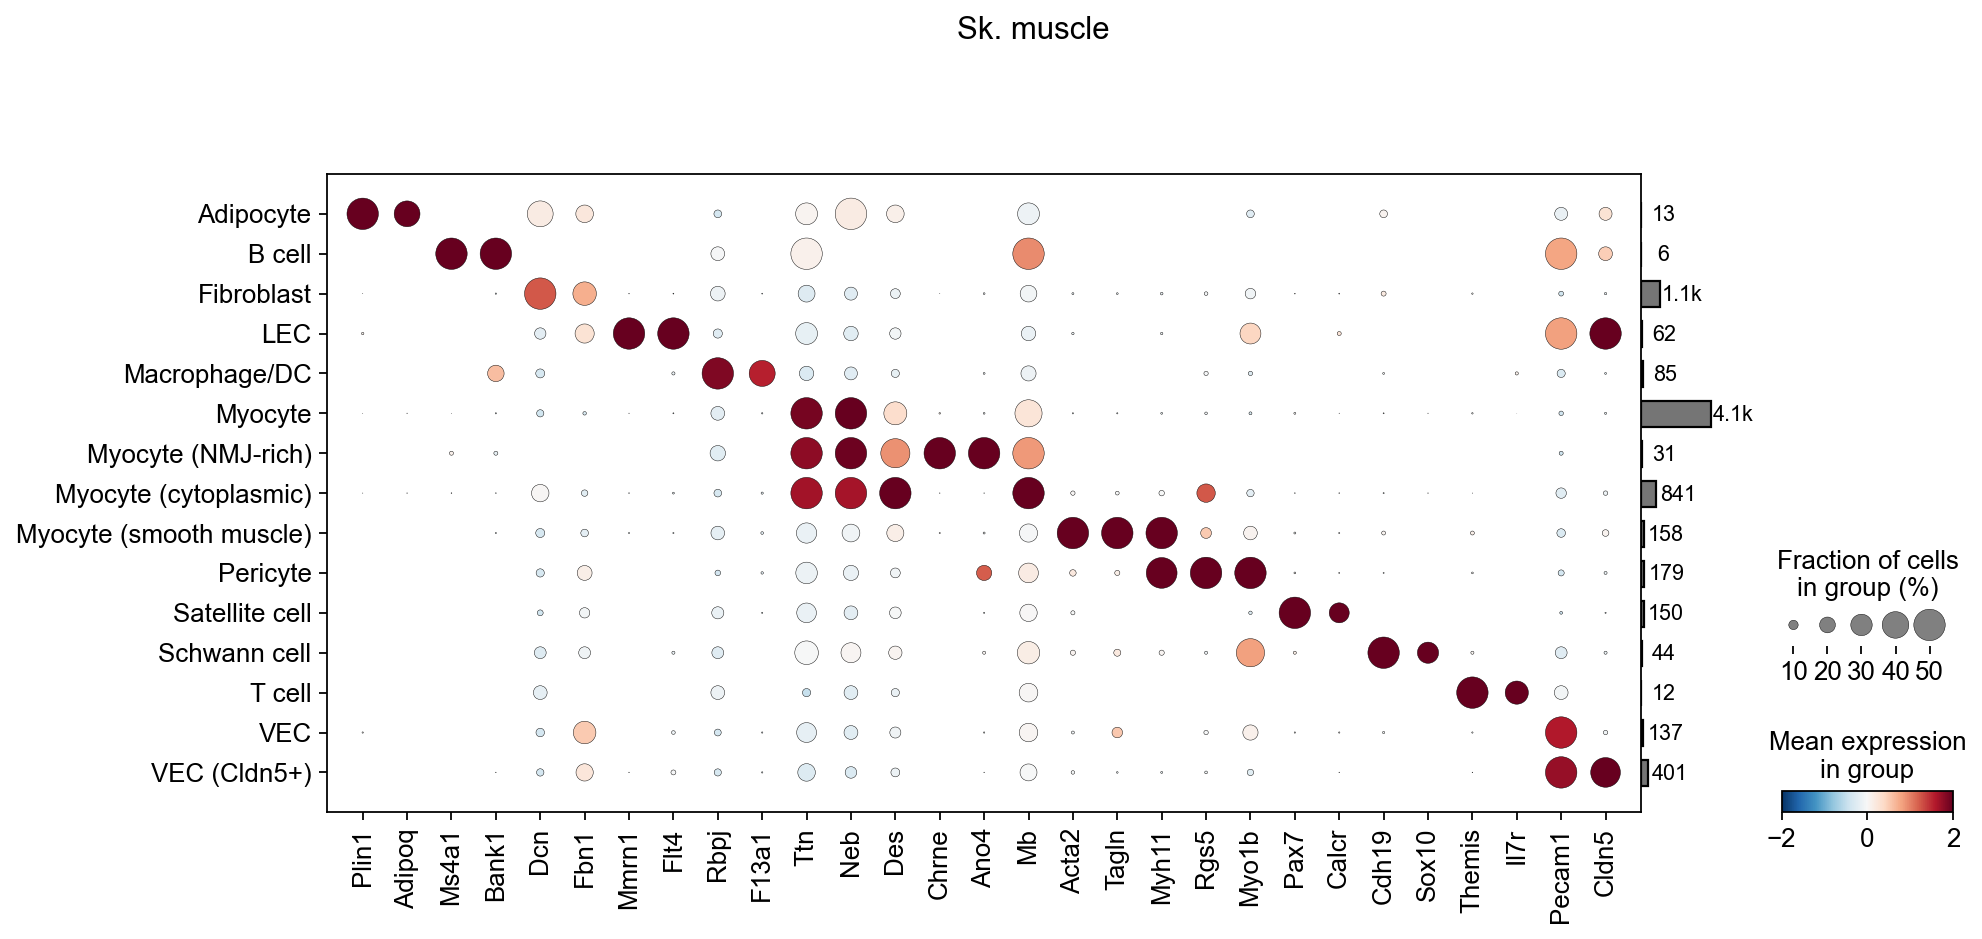

In [19]:
g = sc.pl.dotplot(ad, 
                  var_names=['Plin1', 'Adipoq', 'Ms4a1', 'Bank1', 
                             'Dcn', 'Fbn1', 'Mmrn1', 'Flt4', 'Rbpj', 'F13a1', 
                             'Ttn', 'Neb', 'Des', 
                             'Chrne', 'Ano4','Mb', 
                             'Acta2', 'Tagln','Myh11', 
                             'Rgs5', 'Myo1b',
                             'Pax7', 'Calcr', 'Cdh19', 'Sox10', 
                             'Themis', 'Il7r',
                             'Pecam1', 'Cldn5'],
                  layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', groupby='Cell type', title='Sk. muscle', dot_max=.5, return_fig=True)
g.add_totals(color='#757575')
g.savefig('figures/Figure-S04-1G-1.pdf');

### Heart

In [20]:
ad = adata[adata.obs.Region == 'heart']

In [21]:
#df = run_spring(ad, 'Cell type')
#dotplot_spring(ad, 'Cell type')

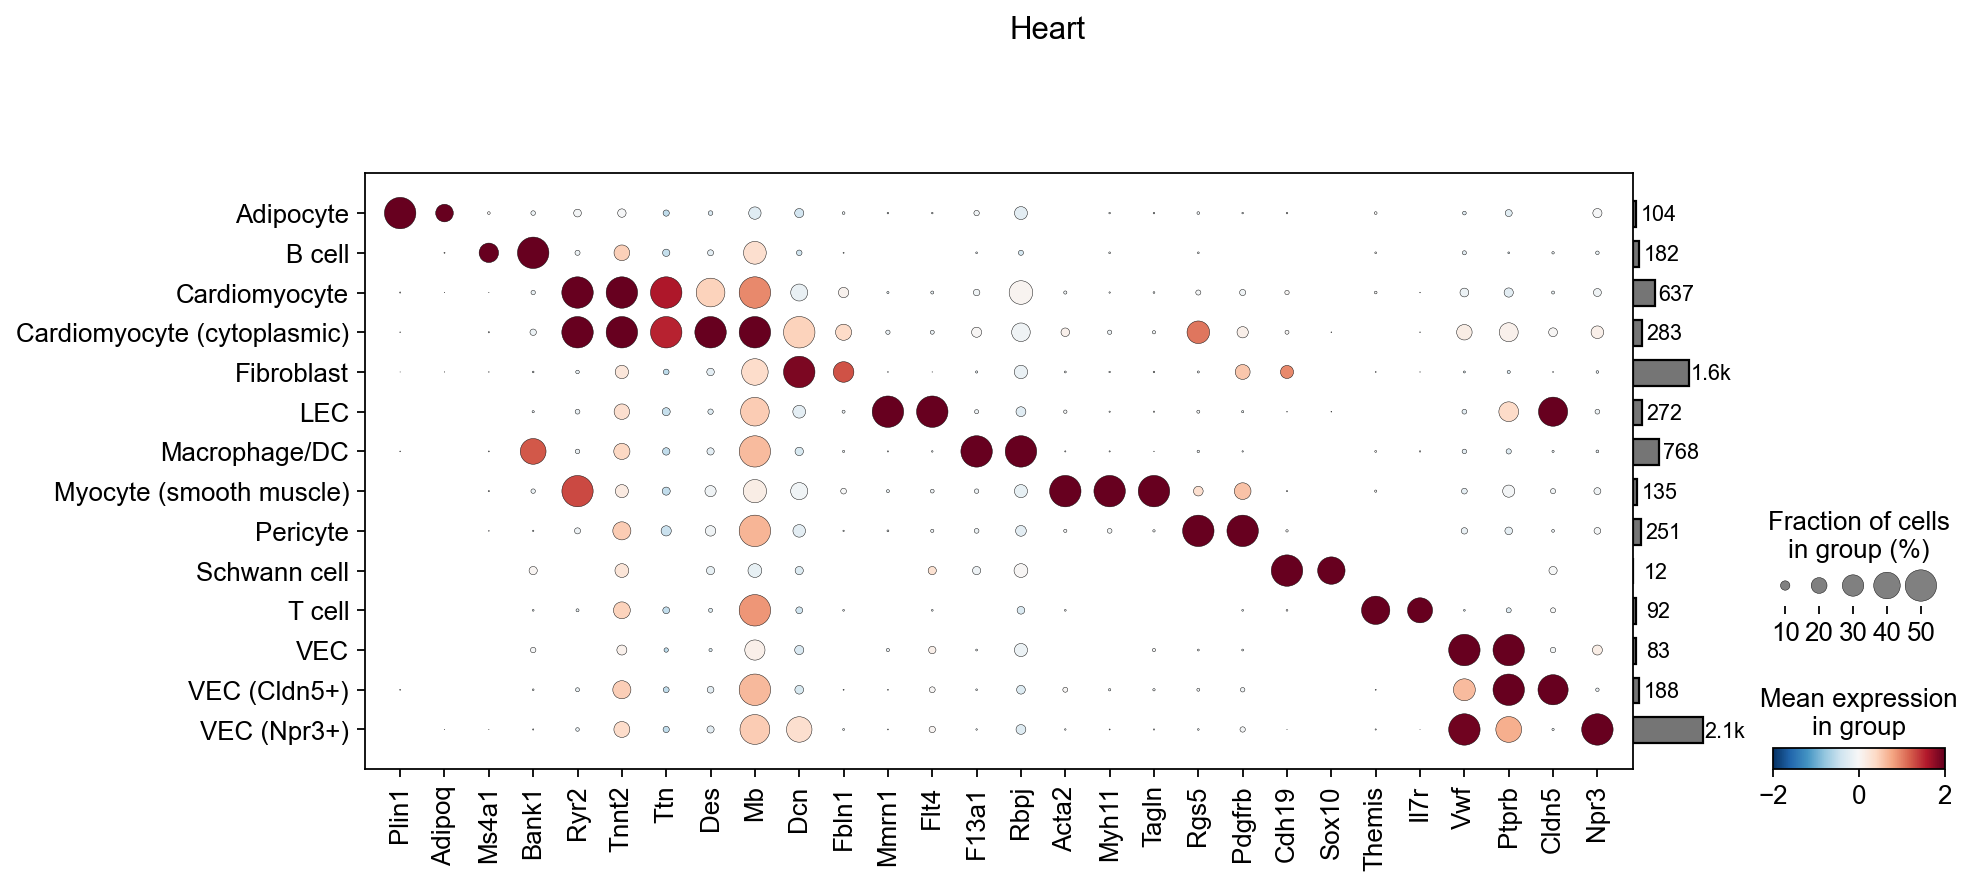

In [22]:
g = sc.pl.dotplot(ad, 
                  var_names=['Plin1', 'Adipoq', 'Ms4a1', 'Bank1', 
                             'Ryr2', 'Tnnt2', 'Ttn', 'Des', 'Mb',
                             'Dcn', 'Fbln1', 'Mmrn1', 'Flt4', 
                             'F13a1', 'Rbpj', 
                             'Acta2', 'Myh11', 'Tagln', 
                             'Rgs5', 'Pdgfrb', 
                             'Cdh19', 'Sox10', 
                             'Themis', 'Il7r', 
                             'Vwf', 'Ptprb', 'Cldn5', 'Npr3'
                             ], 
                  layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', groupby='Cell type', title='Heart', dot_max=.5, return_fig=True)
g.add_totals(color='#757575')
g.savefig('figures/Figure-S04-1G-2.pdf');

### Esophagus

In [23]:
ad = adata[adata.obs.Region == 'esophagus']

In [24]:
#df = run_spring(ad, 'Cell type')
#dotplot_spring(ad, 'Cell type')

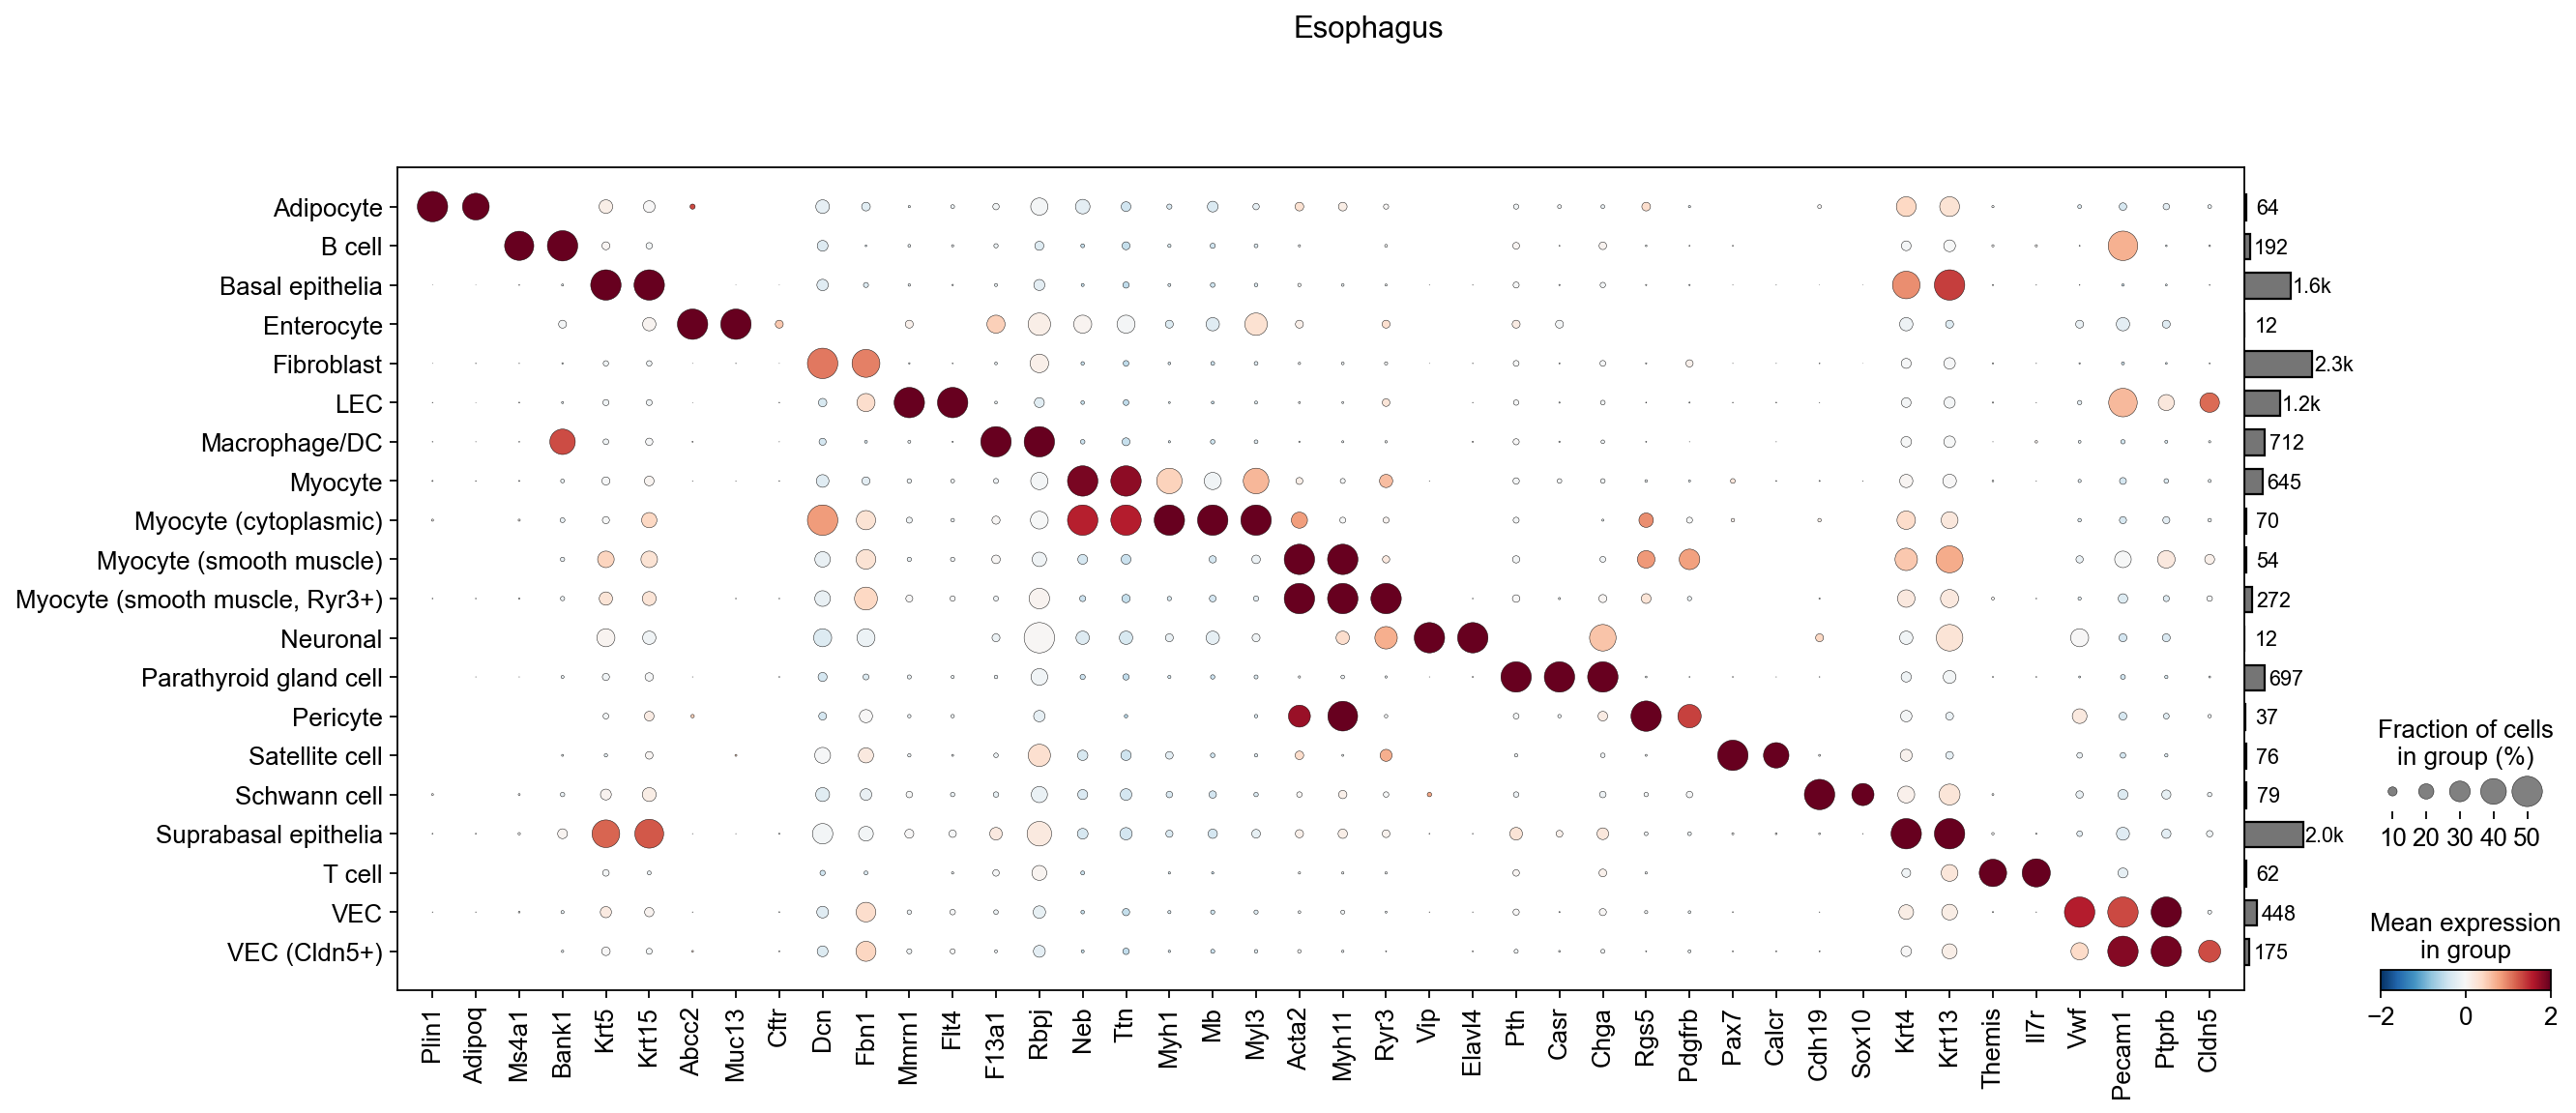

In [27]:
g = sc.pl.dotplot(ad, 
                  var_names=['Plin1', 'Adipoq', 'Ms4a1', 'Bank1', 'Krt5', 
                             'Krt15', 
                             'Abcc2', 'Muc13','Cftr',
                             'Dcn', 'Fbn1', 'Mmrn1', 'Flt4', 
                             'F13a1', 'Rbpj', 'Neb', 'Ttn', 'Myh1', 
                             'Mb', 'Myl3', 
                             'Acta2', 'Myh11', 'Ryr3', 
                             'Vip', 'Elavl4','Pth', 'Casr', 
                             'Chga', 'Rgs5', 'Pdgfrb', 'Pax7', 
                             'Calcr', 'Cdh19', 'Sox10', 
                             'Krt4', 'Krt13', 'Themis', 'Il7r', 
                             'Vwf', 'Pecam1', 'Ptprb', 'Cldn5'], 
                  layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', groupby='Cell type', title='Esophagus', dot_max=.5, return_fig=True)
g.add_totals(color='#757575')
g.savefig('figures/Figure-S04-1G-3.pdf');